In [2]:
import pandas as pd
import numpy as np
import glob
import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns

root_dir = '/oak/stanford/groups/horence/rob/isoform_localizations/'

sys.path.append(os.path.join(root_dir,'scripts'))
import spatial_utils
import plot_utils

Description of the metric

0. Running this new metric on only cells where the total spots per cell is 90th quantile
--> This is different than the gene-centric q90 filtering I’ve been doing, but makes sense here

1. For each spot in each cell, I will calculate the min distance to the cell boundary

2. Then I will rank each spot's distance from the cell boundary and normalize to be between 0 and 1
   
The closest spot will get a rank of 0, the furthest spot will get a rank of 1

3. Then I'll calculate the median normalized rank of each gene in each cell

This will give me a table with number of rows equal to C*G

Then over all cells I can find the mean gene-percentile if I want to summarize over all cells


# Creating the metric

In [3]:
#Use the previously subsamples cells in the q90
spots = pd.read_csv('../processed_data/q90_rna_spots.csv')
cells = pd.read_csv('../processed_data/q90_cells.csv')

In [4]:
spots.head()

,global_x,global_y,global_z,target_molecule_name,num_assigned_cells,cell_id,sample
0,-4237.7397,1681.8490,0.0,Acta2,1,217951229059897556843731256135790480948,mouse1sample2
1,-4215.4233,1699.2443,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2
2,-4207.3945,1706.8620,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2
3,-4206.7200,1711.7010,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2
4,-4270.8410,1726.0154,0.0,Acta2,1,29559620824861669263446897425219499530,mouse1sample2


In [5]:
shared_cell_ids = np.intersect1d(spots['cell_id'], cells['cell_id'])
shared_cell_ids

array(['100024126192764500990464846159908804485',
       '100038053095457998072343452615211305922',
       '100042292675978612289781789372249900646', ...,
       '99969166454721663399298872433695962292',
       '99985816691327783828891364793469425625',
       '99997470167777465101376150817407669505'], dtype=object)

In [46]:

import importlib
importlib.reload(spatial_utils)

def spatial_metric_periphery_rank(spots,cells):
    #Remove cells that have too few boundary points
    #Having 3 commas means 4 points which is min for shapely
    cells = cells[cells['boundaryX'].str.count(',').gt(3)]

    #Limit the spots to just the shared cell_ids
    shared_cell_ids = np.intersect1d(spots['cell_id'], cells['cell_id'])
    spots = spots[spots['cell_id'].isin(shared_cell_ids)]
    cells = cells[cells['cell_id'].isin(shared_cell_ids)]

    #Calculate num_cell_spots and num_gene_spots
    spots = spatial_utils.calculate_spots_per_cell(spots) #NOTE

    #Calculate spot to boundary min dist
    spots = spatial_utils.calculate_spot_to_boundary_min_dist(spots, cells) #NOTE
    spots = spots.rename(columns={'min_boundary_dist':'raw_metric'})
    
    #Calculate normalized spot ranks
    spots['raw_metric'] = (
        spots.groupby('cell_id')['raw_metric']
        .transform(
            lambda x: [(x <= v).sum()/len(x) for v in x]
        )
    )
          
    
    periphery_df = (
        spots.groupby(
            ['cell_id','target_molecule_name','num_cell_spots','num_gene_spots']
        )['raw_metric']
        .quantile(0.5) #currently just the median
        .reset_index()
    )
    
    periphery_df['metric_name'] = 'periphery_ranks'
    
    #Get the output into the standard metric table
    cols = [
       'cell_id', 'target_molecule_name',
       'num_cell_spots', 'num_gene_spots',
       'metric_name', 'raw_metric',
    ]
    metric_df = periphery_df[cols]


    return metric_df


sub_shared_cell_ids = np.random.choice(shared_cell_ids,500)
sub_spots = spots[spots['cell_id'].isin(sub_shared_cell_ids)]
sub_cells = cells[cells['cell_id'].isin(sub_shared_cell_ids)]
        
        
x = spatial_metric_periphery_rank(sub_spots,sub_cells)
x.head()

,cell_id,target_molecule_name,num_cell_spots,num_gene_spots,metric_name,raw_metric
0,100540300693980397235575943695262086238,Acta2,853,2,periphery_ranks,0.332356
1,100540300693980397235575943695262086238,Adra1b,853,3,periphery_ranks,0.801876
2,100540300693980397235575943695262086238,Ano4,853,4,periphery_ranks,0.707503
3,100540300693980397235575943695262086238,Aqp4,853,2,periphery_ranks,0.463658
4,100540300693980397235575943695262086238,B4galnt3,853,1,periphery_ranks,0.094959


In [67]:
x.head()

,cell_id,target_molecule_name,num_cell_spots,num_gene_spots,metric_name,raw_metric
0,100540300693980397235575943695262086238,Acta2,853,2,periphery_ranks,0.332356
1,100540300693980397235575943695262086238,Adra1b,853,3,periphery_ranks,0.801876
2,100540300693980397235575943695262086238,Ano4,853,4,periphery_ranks,0.707503
3,100540300693980397235575943695262086238,Aqp4,853,2,periphery_ranks,0.463658
4,100540300693980397235575943695262086238,B4galnt3,853,1,periphery_ranks,0.094959


In [53]:
x.groupby('cell_id')['target_molecule_name'].unique().apply(len).median()

114.0

In [68]:
x['cell_id'].unique().size

495

In [52]:
x['num_gene_spots'].mean()

8.282551434469994

In [47]:
rand_genes = np.random.choice(x['target_molecule_name'].unique(),10)
rand_genes

array(['Epha7', 'Dscaml1', 'Muc20', 'Slc30a3', 'Prr16', 'Cux2',
       '1700022I11Rik', 'Flt1', 'Tmem163', 'Adamts2'], dtype=object)

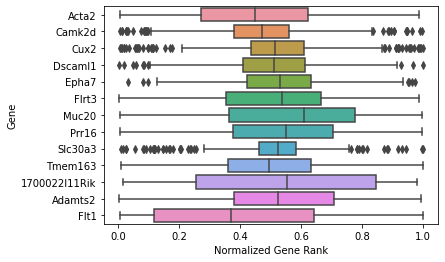

In [54]:
genes = ['Acta2','Flrt3','Camk2d']+list(rand_genes)

sns.boxplot(
    y = 'target_molecule_name',
    x = 'raw_metric',
    data = x[x['target_molecule_name'].isin(genes)],
)
plt.ylabel('Gene')
plt.xlabel('Normalized Gene Rank')
plt.show()
plt.close()

In [77]:
summary_df = x.groupby('target_molecule_name').agg('median').reset_index().sort_values('raw_metric')
summary_df.head()

,target_molecule_name,num_cell_spots,num_gene_spots,raw_metric
231,Timp3,886.0,2.0,0.298452
61,Cldn5,921.0,1.0,0.304462
77,Cxcl14,878.5,2.0,0.307617
12,Aqp4,879.5,2.0,0.325963
75,Ctss,890.0,1.0,0.334879


In [78]:
summary_df = x.groupby('target_molecule_name').agg('median').reset_index().sort_values('raw_metric',ascending=False)
summary_df.head()

,target_molecule_name,num_cell_spots,num_gene_spots,raw_metric
1,1810046K07Rik,938.0,1.0,0.799708
68,Col24a1,916.5,1.5,0.792883
70,Corin,907.0,1.0,0.767634
22,Blank-2,935.0,1.0,0.751696
66,Col15a1,893.5,2.0,0.747044


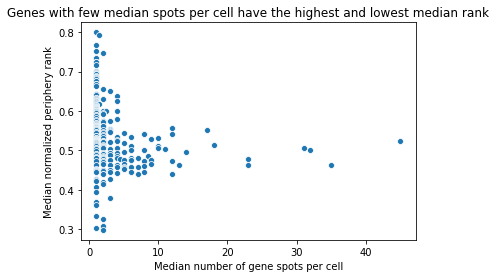

In [80]:
sns.scatterplot(
    x = 'num_gene_spots',
    y = 'raw_metric',
    data = summary_df,
)
plt.title('Genes with few median spots per cell have the highest and lowest median rank')
plt.xlabel('Median number of gene spots per cell')
plt.ylabel('Median normalized periphery rank')
plt.show()
plt.close()


In [75]:
summary_df[summary_df['num_gene_spots'].ge(10)]

,target_molecule_name,num_cell_spots,num_gene_spots,raw_metric
111,Igfbp5,881.0,12.0,0.439725
33,C1ql3,884.0,23.0,0.462321
221,Syndig1,883.0,13.0,0.463942
198,Satb2,881.0,35.0,0.464053
37,Camk2d,881.0,12.0,0.472595
183,Ptprt,881.0,23.0,0.479469
171,Pou3f3,882.0,14.0,0.495595
220,Sulf2,889.0,32.0,0.500000
205,Shisa9,881.0,11.0,0.503862
92,Fezf2,889.0,10.0,0.506080


# Analyzing all cells from the sbatch run

Run all all q90 cells, not just the 500 random ones above

In [52]:
df = pd.read_csv('../processed_data/rank_periph.csv')
df.head()

,cell_id,target_molecule_name,num_cell_spots,num_gene_spots,metric_name,raw_metric
0,100024126192764500990464846159908804485,1700022I11Rik,841,1,periphery_ranks,0.048751
1,100024126192764500990464846159908804485,Acta2,841,4,periphery_ranks,0.894768
2,100024126192764500990464846159908804485,Adam2,841,1,periphery_ranks,0.752675
3,100024126192764500990464846159908804485,Adamts4,841,1,periphery_ranks,0.859691
4,100024126192764500990464846159908804485,Adra1b,841,26,periphery_ranks,0.325208


In [5]:
gene_summary_df = df.groupby('target_molecule_name')[['num_cell_spots','num_gene_spots','raw_metric']].median().reset_index()
gene_summary_df.head()

,target_molecule_name,num_cell_spots,num_gene_spots,raw_metric
0,1700022I11Rik,916.0,1.0,0.613456
1,1810046K07Rik,916.0,1.0,0.735475
2,5031425F14Rik,931.0,1.0,0.649689
3,5730522E02Rik,911.0,1.0,0.655572
4,Acta2,900.0,2.0,0.436419


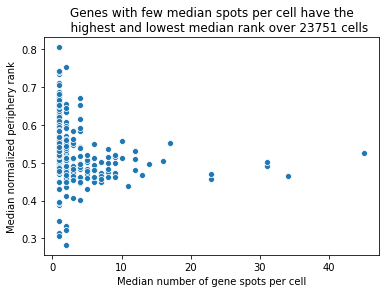

In [6]:
sns.scatterplot(
    x = 'num_gene_spots',
    y = 'raw_metric',
    data = gene_summary_df,
)
plt.title(
    """Genes with few median spots per cell have the
    highest and lowest median rank over {} cells"""
    .format(df['cell_id'].unique().size)
)
plt.xlabel('Median number of gene spots per cell')
plt.ylabel('Median normalized periphery rank')
plt.show()
plt.close()

# For each gene, limit to cells where that gene is q90

In [7]:
df['gene_q90'] = df.groupby('target_molecule_name')['num_gene_spots'].transform(np.quantile,0.9)
df.head()

,cell_id,target_molecule_name,num_cell_spots,num_gene_spots,metric_name,raw_metric,gene_q90
0,100024126192764500990464846159908804485,1700022I11Rik,841,1,periphery_ranks,0.048751,1
1,100024126192764500990464846159908804485,Acta2,841,4,periphery_ranks,0.894768,5
2,100024126192764500990464846159908804485,Adam2,841,1,periphery_ranks,0.752675,2
3,100024126192764500990464846159908804485,Adamts4,841,1,periphery_ranks,0.859691,4
4,100024126192764500990464846159908804485,Adra1b,841,26,periphery_ranks,0.325208,31


In [8]:
df.head()

,cell_id,target_molecule_name,num_cell_spots,num_gene_spots,metric_name,raw_metric,gene_q90
0,100024126192764500990464846159908804485,1700022I11Rik,841,1,periphery_ranks,0.048751,1
1,100024126192764500990464846159908804485,Acta2,841,4,periphery_ranks,0.894768,5
2,100024126192764500990464846159908804485,Adam2,841,1,periphery_ranks,0.752675,2
3,100024126192764500990464846159908804485,Adamts4,841,1,periphery_ranks,0.859691,4
4,100024126192764500990464846159908804485,Adra1b,841,26,periphery_ranks,0.325208,31


In [ ]:
df.groupby('target_molecule_name').transform(lambda g: g['num_gene_spots'])

In [13]:
gene_summary_df

,target_molecule_name,num_cell_spots,num_gene_spots,raw_metric
0,1700022I11Rik,916.0,1.0,0.613456
1,1810046K07Rik,916.0,1.0,0.735475
2,5031425F14Rik,931.0,1.0,0.649689
3,5730522E02Rik,911.0,1.0,0.655572
4,Acta2,900.0,2.0,0.436419
...,...,...,...,...
247,Vtn,912.0,1.0,0.477407
248,Vwc2,920.0,1.0,0.541971
249,Wipf3,893.0,31.0,0.501339
250,Wnt7b,905.0,3.0,0.454883


In [19]:
filt_metric_map = (
    df[df['num_gene_spots'].ge(df['gene_q90'])]
    .groupby('target_molecule_name')
    ['raw_metric']
    .median()
)

gene_summary_df['filtered_metric'] = gene_summary_df['target_molecule_name'].map(filt_metric_map)
gene_summary_df.head()

,target_molecule_name,num_cell_spots,num_gene_spots,raw_metric,filtered_metric
0,1700022I11Rik,916.0,1.0,0.613456,0.613456
1,1810046K07Rik,916.0,1.0,0.735475,0.707237
2,5031425F14Rik,931.0,1.0,0.649689,0.649689
3,5730522E02Rik,911.0,1.0,0.655572,0.652889
4,Acta2,900.0,2.0,0.436419,0.432281


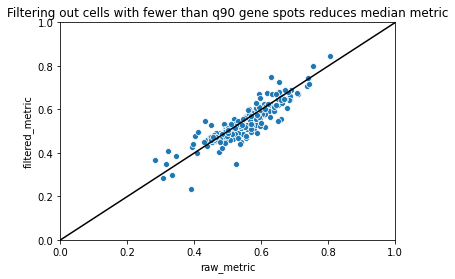

In [31]:
sns.scatterplot(
    x = 'raw_metric',
    y = 'filtered_metric',
    data = gene_summary_df,
)
plt.plot([0,1],[0,1],'k')
plt.xlim(0,1)
plt.ylim(0,1)

plt.title('Filtering out cells with fewer than q90 gene spots reduces median metric')
plt.show()
plt.close()

In [34]:
gene_summary_df.head()

,target_molecule_name,num_cell_spots,num_gene_spots,raw_metric,filtered_metric
0,1700022I11Rik,916.0,1.0,0.613456,0.613456
1,1810046K07Rik,916.0,1.0,0.735475,0.707237
2,5031425F14Rik,931.0,1.0,0.649689,0.649689
3,5730522E02Rik,911.0,1.0,0.655572,0.652889
4,Acta2,900.0,2.0,0.436419,0.432281


In [40]:
mgsdf = gene_summary_df.melt(
    id_vars = ['target_molecule_name','num_gene_spots'],
    value_vars = ['raw_metric','filtered_metric'],
    var_name = 'filtering',
    value_name = 'median_metric',
)

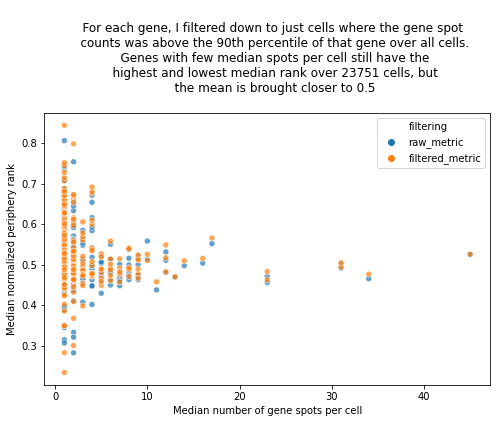

In [50]:
fig = plt.figure(figsize=(8,5))
sns.scatterplot(
    x = 'num_gene_spots',
    y = 'median_metric',
    hue = 'filtering',
    alpha = 0.7,
    data = mgsdf,
)
plt.title(
    """
    For each gene, I filtered down to just cells where the gene spot 
    counts was above the 90th percentile of that gene over all cells.
    Genes with few median spots per cell still have the
    highest and lowest median rank over {} cells, but
    the mean is brought closer to 0.5
    """
    .format(df['cell_id'].unique().size)
)
plt.xlabel('Median number of gene spots per cell')
plt.ylabel('Median normalized periphery rank')
plt.show()
plt.close()

In [51]:
df.head()

,cell_id,target_molecule_name,num_cell_spots,num_gene_spots,metric_name,raw_metric,gene_q90
0,100024126192764500990464846159908804485,1700022I11Rik,841,1,periphery_ranks,0.048751,1
1,100024126192764500990464846159908804485,Acta2,841,4,periphery_ranks,0.894768,5
2,100024126192764500990464846159908804485,Adam2,841,1,periphery_ranks,0.752675,2
3,100024126192764500990464846159908804485,Adamts4,841,1,periphery_ranks,0.859691,4
4,100024126192764500990464846159908804485,Adra1b,841,26,periphery_ranks,0.325208,31


# Analyzing dropping a hard threshold on number of reads per cell

In [53]:
df = pd.read_csv('../processed_data/rank_periph.csv')
df.head()

,cell_id,target_molecule_name,num_cell_spots,num_gene_spots,metric_name,raw_metric
0,100024126192764500990464846159908804485,1700022I11Rik,841,1,periphery_ranks,0.048751
1,100024126192764500990464846159908804485,Acta2,841,4,periphery_ranks,0.894768
2,100024126192764500990464846159908804485,Adam2,841,1,periphery_ranks,0.752675
3,100024126192764500990464846159908804485,Adamts4,841,1,periphery_ranks,0.859691
4,100024126192764500990464846159908804485,Adra1b,841,26,periphery_ranks,0.325208


In [58]:
hard_threshold = 10
ht_df = (
    df[df['num_gene_spots'].ge(hard_threshold)]
    .groupby('target_molecule_name')
    [['raw_metric','num_gene_spots']]
    .quantile(0.5)
    .reset_index()
    .rename(columns={
        'raw_metric':'median_score_ht{}'.format(hard_threshold),
        'num_gene_spots':'median_gene_spots_ht{}'.format(hard_threshold),
    })
)

ht_df.head()

,target_molecule_name,median_score_ht10,median_gene_spots_ht10
0,Acta2,0.507763,36.0
1,Adamts2,0.559757,13.0
2,Adamts4,0.511494,30.0
3,Adra1b,0.471722,20.0
4,Alk,0.559895,14.0


In [60]:
ht_df.sort_values('median_score_ht10',ascending=True)

,target_molecule_name,median_score_ht10,median_gene_spots_ht10
55,Ctss,0.242999,16.0
78,Gfap,0.341080,23.0
7,Aqp4,0.370546,15.0
135,Pdgfra,0.380901,16.0
42,Clrn1,0.394338,15.0
...,...,...,...
196,Teddm3,0.741379,13.0
99,Lama3,0.758488,12.0
27,Ccnb1,0.760638,12.0
46,Col15a1,0.796783,13.0


In [61]:
ht_df.sort_values('median_score_ht10',ascending=False)

,target_molecule_name,median_score_ht10,median_gene_spots_ht10
48,Col24a1,0.843529,15.0
46,Col15a1,0.796783,13.0
27,Ccnb1,0.760638,12.0
99,Lama3,0.758488,12.0
196,Teddm3,0.741379,13.0
...,...,...,...
42,Clrn1,0.394338,15.0
135,Pdgfra,0.380901,16.0
7,Aqp4,0.370546,15.0
78,Gfap,0.341080,23.0


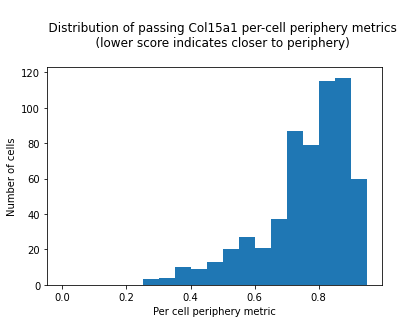

In [91]:
gene = 'Col15a1'

df[
    df['target_molecule_name'].eq(gene) &
    df['num_gene_spots'].ge(hard_threshold)
]['raw_metric'].plot.hist(bins=np.arange(0,1,0.05))
plt.title(
    """
    Distribution of passing {} per-cell periphery metrics
    (lower score indicates closer to periphery)
    """.format(gene)
)
plt.xlabel('Per cell periphery metric')
plt.ylabel('Number of cells')
plt.show()
plt.close()

In [68]:
cells = pd.read_csv('../processed_data/q90_cells.csv')
spots = pd.read_csv('../processed_data/q90_rna_spots.csv')

In [92]:
df[
    df['target_molecule_name'].eq('Ctss') &
    df['num_gene_spots'].ge(10)
].sort_values('raw_metric',ascending=True)

,cell_id,target_molecule_name,num_cell_spots,num_gene_spots,metric_name,raw_metric
1975689,322560017854953834175380386468164396897,Ctss,752,16,periphery_ranks,0.024601
608776,168587402537235472371475413390171145840,Ctss,945,16,periphery_ranks,0.029101
1010322,214428992059768121498703678670305840635,Ctss,848,12,periphery_ranks,0.030071
227104,125913901407470871730501245525836017282,Ctss,1341,16,periphery_ranks,0.031693
29835,103525093451753948349601507864400867148,Ctss,913,11,periphery_ranks,0.031763
...,...,...,...,...,...,...
1680868,289416032152307293617986248960493842281,Ctss,939,13,periphery_ranks,0.864750
1918648,316357133461215628947453365163628392298,Ctss,897,12,periphery_ranks,0.870123
1660728,287407755666192798043067167488714399262,Ctss,1048,10,periphery_ranks,0.887405
2605686,8843179902962671870295343944102719264,Ctss,1616,14,periphery_ranks,0.889233


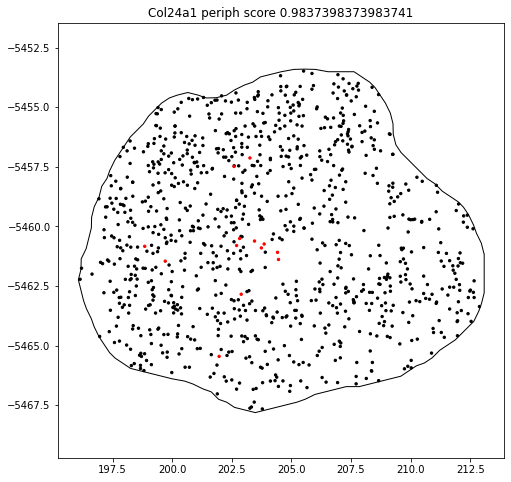

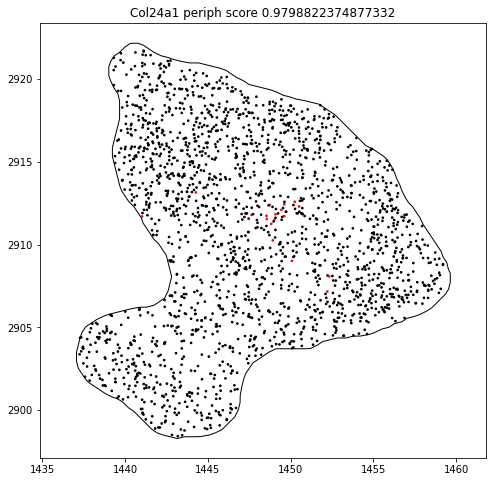

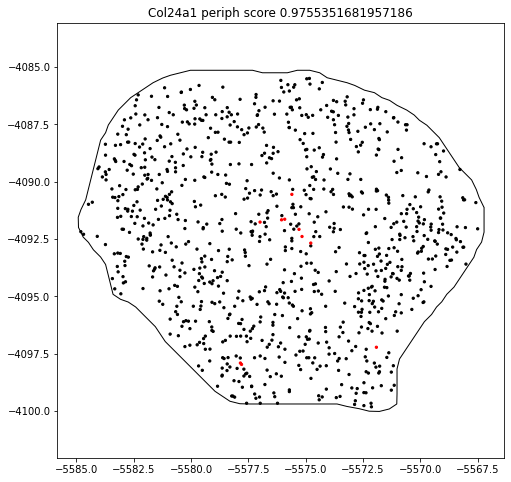

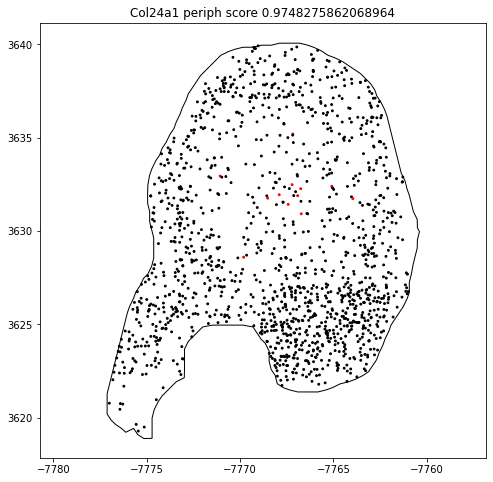

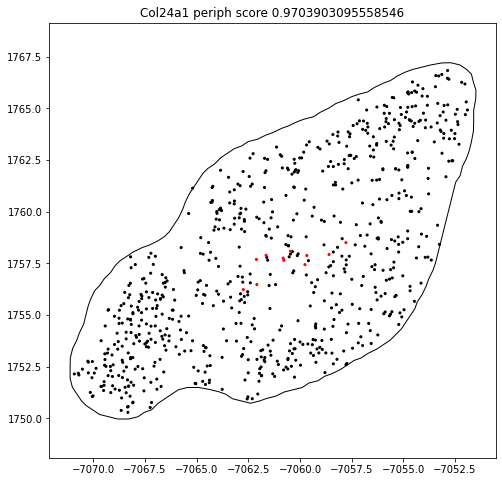

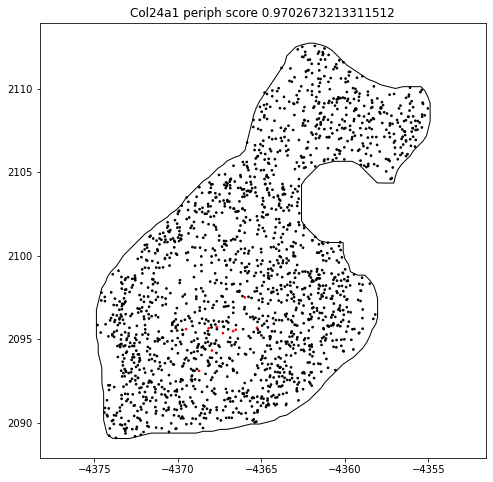

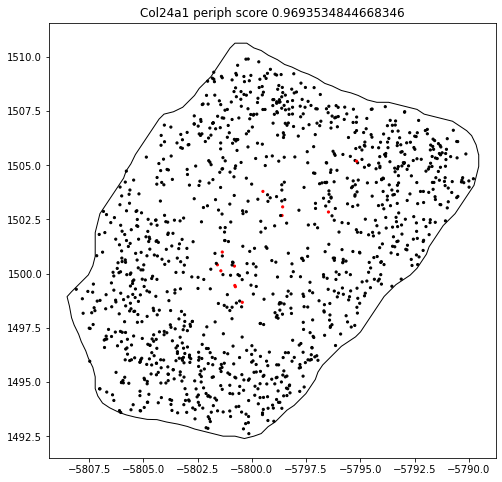

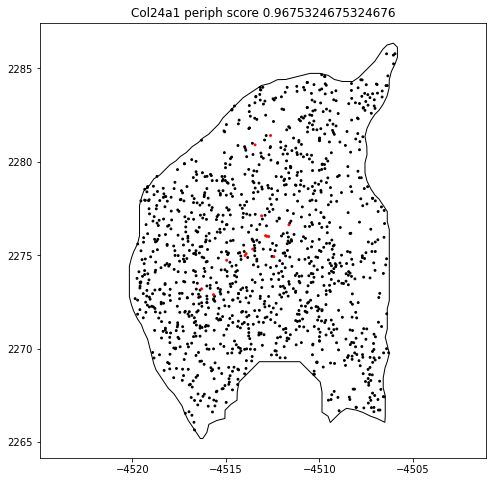

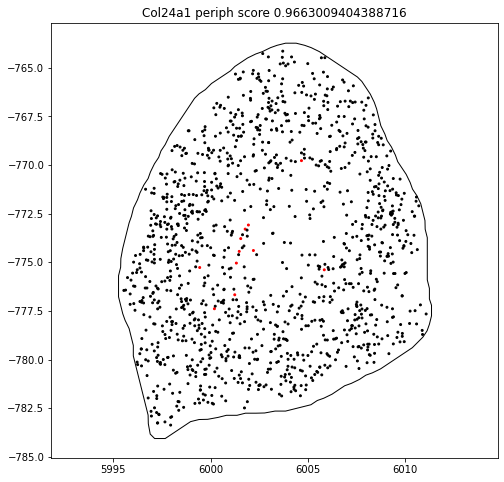

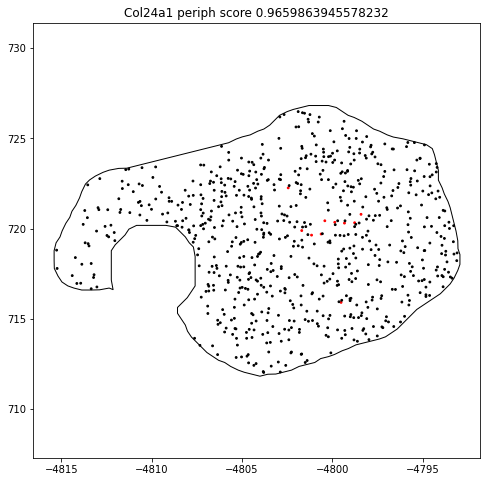

In [93]:
ctss_periphs = df[
    df['target_molecule_name'].eq('Col24a1') &
    df['num_gene_spots'].ge(hard_threshold)
].sort_values('raw_metric',ascending=False).head(10)


for i,r in ctss_periphs.iterrows():
    cell_id = [r['cell_id']]
    sub_spots = spots[spots['cell_id'].isin(cell_id)]
    sub_cells = cells[cells['cell_id'].isin(cell_id)]

    fig,ax = plot_utils.plot_spot_cells(sub_spots, sub_cells, spot_colors={'Col24a1':'r'})
    plt.title('Col24a1 periph score {}'.format(r['raw_metric']))
    plt.show()
    plt.close()

# Looking at middle of the pack genes, extreme scores

In [87]:
ht_df[ht_df['median_score_ht10'].between(0.48,0.52)]

,target_molecule_name,median_score_ht10,median_gene_spots_ht10
0,Acta2,0.507763,36.0
2,Adamts4,0.511494,30.0
8,Asic4,0.480245,19.0
10,Barx2,0.484790,12.0
12,Bdnf,0.481396,13.0
...,...,...,...
204,Tnfaip6,0.486344,12.5
205,Tox,0.484318,19.0
213,Unc5b,0.506720,30.0
214,Unc5d,0.495556,15.0


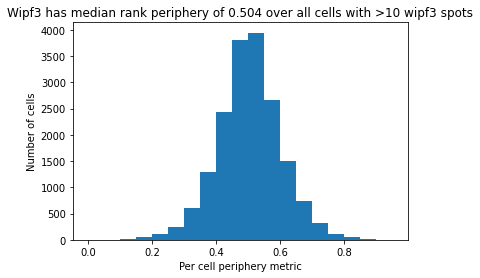

In [96]:
df[
    df['target_molecule_name'].eq('Wipf3') &
    df['num_gene_spots'].ge(hard_threshold)
]['raw_metric'].plot.hist(bins=np.arange(0,1,0.05))
plt.title('Wipf3 has median rank periphery of 0.504 over all cells with >10 wipf3 spots')
plt.xlabel('Per cell periphery metric')
plt.ylabel('Number of cells')
plt.show()
plt.close()

cell_id                 111224926392630212160278934965632123769
target_molecule_name                                      Wipf3
num_cell_spots                                             1140
num_gene_spots                                               10
metric_name                                     periphery_ranks
raw_metric                                             0.903509
Name: 97992, dtype: object


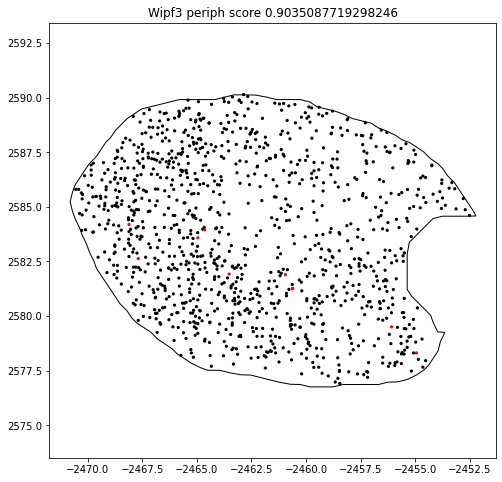

cell_id                 293297913032443531066043515969277628343
target_molecule_name                                      Wipf3
num_cell_spots                                              864
num_gene_spots                                               11
metric_name                                     periphery_ranks
raw_metric                                             0.902778
Name: 1716468, dtype: object


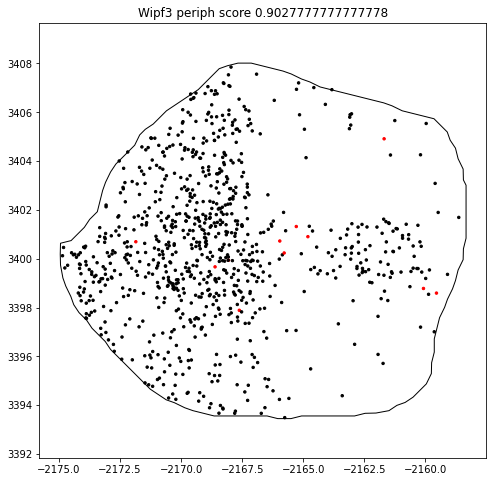

cell_id                 60435697483404839528219955252936817564
target_molecule_name                                     Wipf3
num_cell_spots                                            1159
num_gene_spots                                              12
metric_name                                    periphery_ranks
raw_metric                                            0.901208
Name: 2364245, dtype: object


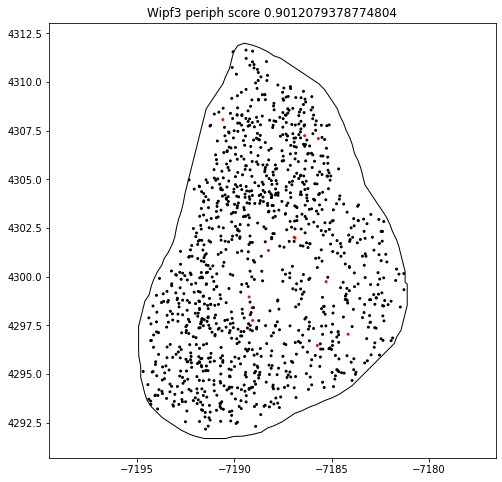

cell_id                 10115851704417008951069150064407447402
target_molecule_name                                     Wipf3
num_cell_spots                                             881
num_gene_spots                                              16
metric_name                                    periphery_ranks
raw_metric                                            0.900114
Name: 10513, dtype: object


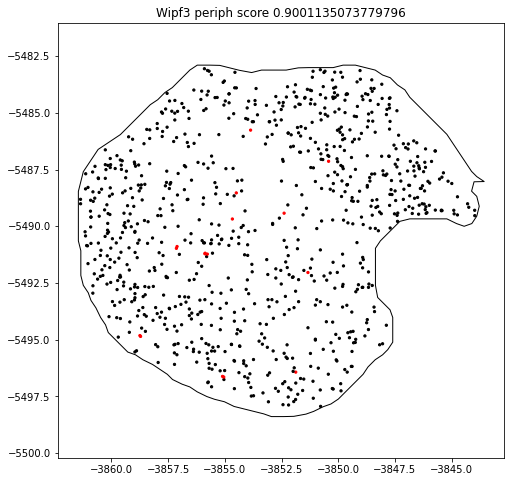

cell_id                 330880828345595939132800023613509253863
target_molecule_name                                      Wipf3
num_cell_spots                                              987
num_gene_spots                                               11
metric_name                                     periphery_ranks
raw_metric                                             0.870314
Name: 2047638, dtype: object


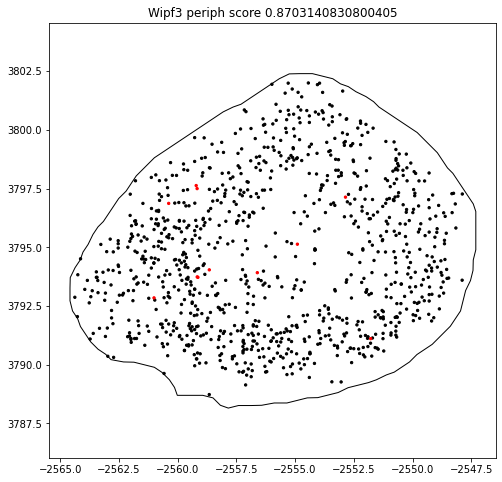

cell_id                 831114238520924087384258155051166413
target_molecule_name                                   Wipf3
num_cell_spots                                          1572
num_gene_spots                                            10
metric_name                                  periphery_ranks
raw_metric                                          0.867048
Name: 2557704, dtype: object


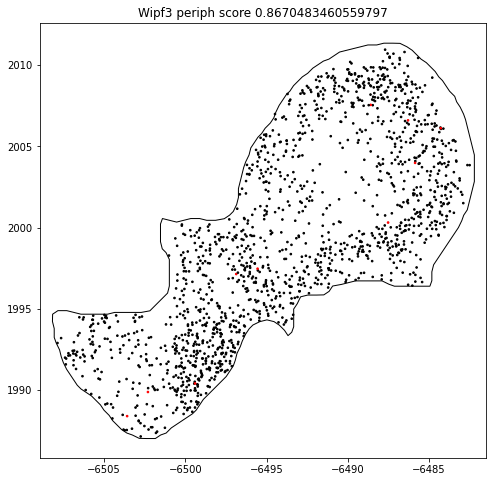

cell_id                 72772679645932007053183315208814179966
target_molecule_name                                     Wipf3
num_cell_spots                                            1384
num_gene_spots                                              11
metric_name                                    periphery_ranks
raw_metric                                            0.866329
Name: 2466197, dtype: object


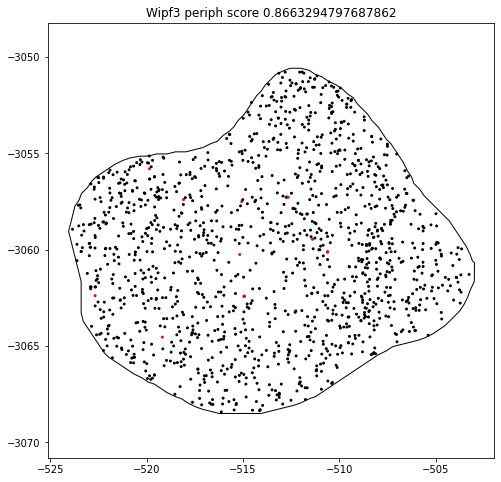

cell_id                 129258726247763718892675877281389348643
target_molecule_name                                      Wipf3
num_cell_spots                                              913
num_gene_spots                                               12
metric_name                                     periphery_ranks
raw_metric                                             0.865827
Name: 255933, dtype: object


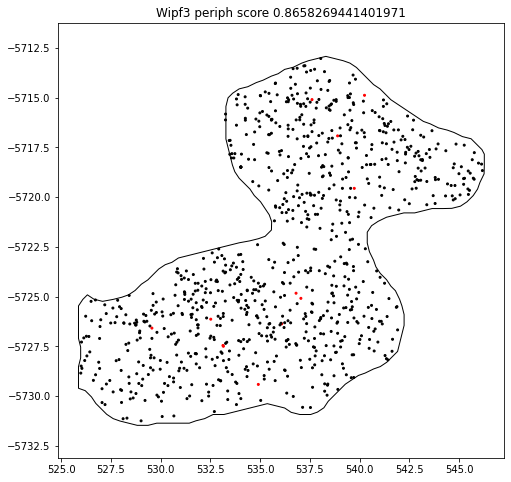

cell_id                 44054999505383282991151602294997925847
target_molecule_name                                     Wipf3
num_cell_spots                                             757
num_gene_spots                                              10
metric_name                                    periphery_ranks
raw_metric                                            0.861955
Name: 2220810, dtype: object


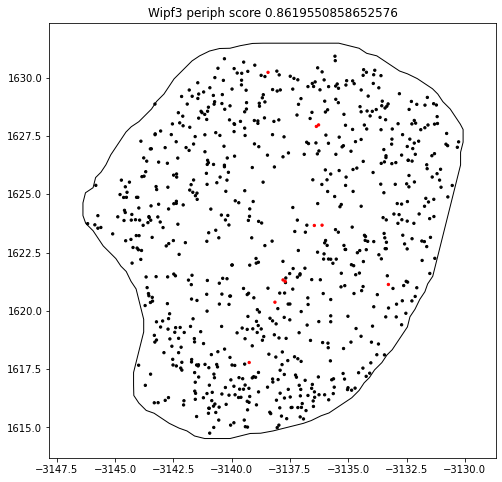

cell_id                 199026264640457093335003040338860087835
target_molecule_name                                      Wipf3
num_cell_spots                                             1250
num_gene_spots                                               13
metric_name                                     periphery_ranks
raw_metric                                               0.8616
Name: 876724, dtype: object


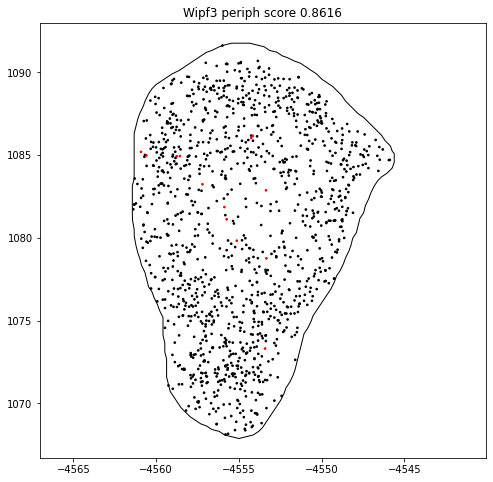

In [102]:
extreme_periphs = df[
    df['target_molecule_name'].eq('Wipf3') &
    df['num_gene_spots'].ge(hard_threshold)
].sort_values('raw_metric',ascending=False).head(10)


for i,r in extreme_periphs.iterrows():
    print(r)
    cell_id = [r['cell_id']]
    sub_spots = spots[spots['cell_id'].isin(cell_id)]
    sub_cells = cells[cells['cell_id'].isin(cell_id)]

    fig,ax = plot_utils.plot_spot_cells(sub_spots, sub_cells, spot_colors={'Wipf3':'r'})
    plt.title('Wipf3 periph score {}'.format(r['raw_metric']))
    plt.show()
    plt.close()

In [103]:
df.head()

,cell_id,target_molecule_name,num_cell_spots,num_gene_spots,metric_name,raw_metric
0,100024126192764500990464846159908804485,1700022I11Rik,841,1,periphery_ranks,0.048751
1,100024126192764500990464846159908804485,Acta2,841,4,periphery_ranks,0.894768
2,100024126192764500990464846159908804485,Adam2,841,1,periphery_ranks,0.752675
3,100024126192764500990464846159908804485,Adamts4,841,1,periphery_ranks,0.859691
4,100024126192764500990464846159908804485,Adra1b,841,26,periphery_ranks,0.325208
